# 3rd Project - 고양이 수염 스티커 만들기

이번 프로젝트는 사람 얼굴을 프로그램이 인식하여 원하는 위치에 고양이 수염모양 스티커를 붙이는 프로젝트이다.   


## Step 1. 모델 얼굴, 스티커 준비하기

### (1) 디렉토리 세팅

```  $ mkdir -p ~/aiffel/camera_sticker/models 
 $ mkdir -p ~/aiffel/camera_sticker/images ```   
    
    
camera_sticker 폴더 안에 models와 images 디렉토리를 생성한다.

### (2) 패키지 다운로드

사람 얼굴을 인식하고 스티커를 붙일 때 필요한 패키지를 다운로드 한다.

```$ pip install opencv-python
 $ pip install cmake
 $ pip install dlib```

추가적으로 이미지를 읽을 때 필요한 패키지인 cv2와 matplotlib, numpy를 import 한다.   


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

모든 준비 끝~!

### (3) 이미지 리사이징

먼저, 준비한 이미지를 위 (1) 디렉토리 세팅에서 설정했던 폴더인 ```images```디렉토리에 준비한다.   
이후 cv2 패키지를 사용하여 이미지를 640 x 360 사이즈로 리사이징 후 카피하여 이미지를 별도로 보관한다.   
   
   

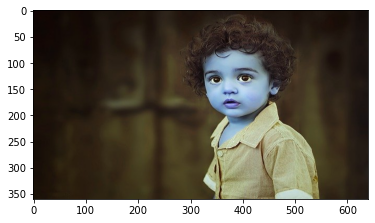

In [3]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path) 
img_bgr = cv2.resize(img_bgr, (640, 360)) 
img_show = img_bgr.copy() 
plt.imshow(img_bgr)
plt.show()

오늘의 모델이 될 귀여운 아이의 이미지가 640x360 사이즈로 리사이징 된 것을 확인할 수 있다.   
opencv의 특성상 이미지는 RGB 순서가 아닌 BGR 순서로 표현되었다. RGB로 다시 바꿔야겠다. 

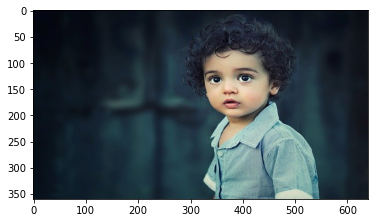

In [4]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

아이의 얼굴색이 다시 돌아왔다 ㅎㅎ

추가적으로, ```img_bgr = cv2.imread(my_image_path)``` 부분에서 매개변수 부분에 1, 0 , -1을 입력하여 색값을 각각 color, grayscale, unchaged로 변경할 수 있다.   
테스트는 해봤지만 과제 내에서 실제로 구현하는 것은 생략하겠다.

# Step 2. 얼굴 검출(Face Detection) & 랜드마크 (Face Landmark) 검출하기

이번 단계에서는 사진에 있는 모델의 얼굴을 찾아 bounding box를 설정하고 랜드마크를 찾아보는 과정이다.

## (1) 얼굴 검출하기

얼굴 검출단계에서는 **HOG(Histogram oriented Gradient)**를 사용하여 사진에서 **빛의 밝기가 변하는 방향**으로 화살표를 만들어보겠다.   
이 과정을 Gradient라고 하는데, 해당 픽셀이 주변 픽셀에 비해서 얼마나 어두운지를 알아내는 과정이다.   
픽셀의 밝은 부분에서 어두운 부분으로 향하는 화살표를 만들면 **얼굴 전체에 밝기에 대한 흐름을 알 수 있게된다**.   
   
   
주의할 점은 모든 픽셀 값에 대해 Gradient를 하는 것이 아니라, 16x16의 픽셀을 지정하여 **개별 픽셀의 흐름보다 사진 전체의 큰 흐름**을 볼 수 있게 한다.

먼저, ```dlib```을 ```import```하여 **hog detector 함수**를 선언한다.

In [5]:
import dlib
detector_hog = dlib.get_frontal_face_detector()

이후 detector를 활용하여 이미지 사진에서 **얼굴에 해당하는 부분**을 찾아보자~!

In [6]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

이미지 피라미드 값에 1을 주어 얼굴을 더 정확히 검출할 수 있도록 하였다.

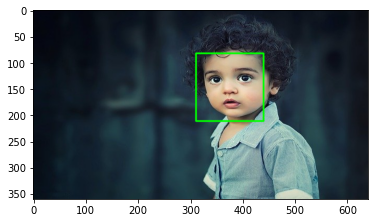

In [7]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

Bounding box형태로 얼굴 부분을 정확히 찾았다. 너무 신기하다.

## (2) 얼굴 랜드마크 검출하기

얼굴을 찾았으니 이제 얼굴에 포인트가 되는 랜드마크를 검출해보자.

### Object keypoint estimation algorithm

객체에 키포인트를 추정하는 알고리즘이다. 이 알고리즘을 사용하는 방법은 두가지가 있다.   
**첫번째**는 Step 2 - (1)의 과정처럼 얼굴의 bounding box를 찾고, 키포인트를 찾는 방법이 있다.   
**두번째**는, 사진 전체에 키포인트를 먼저 찾고, bounding box를 군집화하는 방법이다.   
   
    
이 과제에서는 앞 과정에서 이미 얼굴의 박스를 찾았기 때문에 첫번째 방법을 통해 랜드마크를 검출해보겠다~!   
   
   
_(실제로 얼굴 이미지에 랜드마크를 찾는 데이터베이스는 많이 있다. 이 과정에서는 dlbi에서 제공하는 **ibug 300-W** 데이터셋을 활용하겠다. 이미 학습된 모델로 아래 경로에 맞춰 다운로드 후 모델 폴더에 저장한다.)_

```$ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2``` (트레인된 모델 다운로드)   
```mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models``` (models 디렉토리로 이동)   
```cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2``` (디렉토리로 이동 후 압축해체)

**ibug 300-W** 을 로드한다~!

In [8]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print('ibug 300-W 로드 성공')

ibug 300-W 로드 성공


모델이 성공적으로 로드된다면 위의 print()문이 입력된다.   

이제 사진을 불러와 성공적으로 얼굴에 랜드마크가 입력 되었는지 확인해보자.!

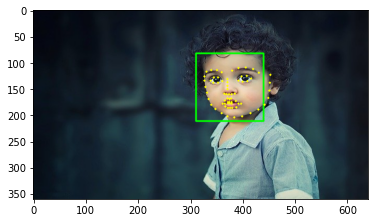

In [9]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

랜드마크 68개가 성공적으로 추출되었다 :)

## Step 3. 스티커 적용 위치 확인하기!

### (1) 스티커 적용하기!!

이제 마지막 단계인, 위에서 추출된 랜드마크를 기준으로 스티커를 적용하면 된다.   

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[8])
    x = landmark[30][0]
    y = landmark[8][0]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(384, 204)
(x,y) : (371,384)
(w,h) : (130,130)


처음 좌표계에 대한 오류가 계속 생겨 랜드마크를 8번 (턱 끝)을 기준으로 시작하였다.   
아기의 턱 끝 좌표는 (384, 204) 이다.

In [11]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(130, 130, 3)


스티커의 원본 사이ㅈ는 512x512인데 130x130x3채널로 리사이징을 하였다.

In [12]:
refined_x = x - w // 2  # left
refined_y = (y - h) //2    # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

refined_y = 90
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (306,127)
(x,y) : (306,90)


스티커의 위치를 맞추기 위해 y좌표의 top을 90정도에 맞추니 정확히 코 지점에 닿았다~!

## Step 4. 스티커 적용하기

### (1) 스티커 적용!

In [13]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

이제 아이 사진에 스티커를 붙이는 과정이다.   
스티커가 붙어지긴 했는데, 몇가지 오류가 있었다.   
   
   
첫번째 오류는 스티커에 흰색 배경이 나와서 아이의 얼굴을 가린다는 것이었다. np.where부분을 수정하여 해결하였다.   
두번째 오류는, 스티커의 x축은 원하는 위치로 옮길 수 있었는데 y축은 값을 변경해도 움직이지 않는다는 것이었다. 얼굴 정중앙에 스티커가 안붙어서 한참 애를 먹었다.   
팀원의 도움을 받아 위 코드부분 첫째줄 ```img_show[refined_y:refined_y+img_sticker.shape[0]```에서 ```refined_y```를 더하니 에러가 해결됐다.   
좌표계에서 오류가 난건데 사실 왜 이런 오류가 생기는 건지 아직 잘 이해가 안됐다.   
opencv에서의 에러라고 하니 더 공부해볼 예정이다.

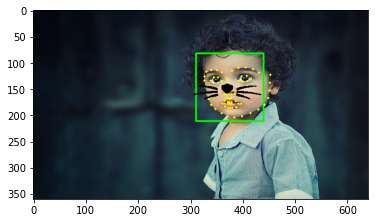

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

고양이 수염이 아이 얼굴에 정확히 위치되었다 ㅎㅎㅎㅎ 

# Step 5. 문제점 찾아보기

### (1) 다양한 사진에 적용해보기

(379, 107)


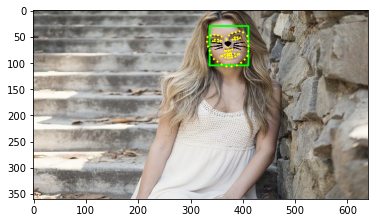

In [23]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image1.jpg'
img_bgr = cv2.imread(my_image_path) 
img_bgr = cv2.resize(img_bgr, (640, 360)) 
img_show = img_bgr.copy() 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
. 
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[8])
    x = landmark[30][0]
    y = landmark[33][0]
    w = dlib_rect.width()
    h = dlib_rect.width()

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2  # left
refined_y = y - h   # top

refined_y = 30

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

내 사진을 사용한게 아니라 다른웹에 오픈되어있는 사진을 사용해서 다른 각도가 아니라 다른 사진을 사용하였는데 정면에 있는 사진의 경우는 대부분 정확히 얼굴을 인식하는것 같았다. 비슷한 사진의 옆각도를 이용했을 때에는 얼굴의 bounding box를 인식하지 못하는 문제가 발생하였고, 어떤 문제가 있는지 확인하지 못하였다.

# 회고:   
### 1. **이번 프로젝트에서 어려웠던 점**   
프로그래밍을 처음 시작하는 사람의 입장에서는 모든 코드들이 낯설다. 하나하나 천천히 뜯어보고 고민하여 이해가 되는 부분도 있지만 이해가 되지 않는 부분도 많다. '이런식으로 구동되어 이런 결과가 나오는구나'정도만 이해하고 넘어가는 것들이다.프로젝트를 진행하면서 어려웠던 점은, 100%이해를 하지 못하고 넘어갔을 때 그 다음 스텝에서도 이해가 되지 않을 확률이 높아지고 결국에는 다 알지도 못하고 프로젝트를 진행하게 되는 일이다. 노력하고 시간을 투자해서 좋은 결과를 내고 내 자신의 발전으로 만들고 싶은게 편하게 물어보고 궁금증을 해결할수 없어서 어렵고 아쉽다.
   
### 2. **프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점**   
Face detection이라는 부분이 여러 과정을 통해 인식하게 된다는 것을 배웠다. 얼굴인식이 사실 현대기술에 있어서는 당연시되듯이 많은 곳에서 사용되고 있는데 직접 구동시켜보려니깐 생각보다 많은 요소들을 고려해야한다는 것을 느꼈다. 특히 숫자로 데이터화된 사진에서 어떻게 얼굴을 찾을까 궁금했는데 그 중 Gradient라는 방법을 통해 빛의 밝기가 이동하는 방향으로 찾아낸다는 것이 개인적으로는 인상깊었다.


### 3. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
\- **자기만의 카메라앱 기능 구현을 완수하였다** - 얼굴 인식에는 문제가 없이 랜드마크까지 추출하였으며, 이후 스티커를 입히는 과정에서 몇가지 오류를 수정하여 (위 과정에 자세히 나와있음) 해결하였음   
\- **스티커 이미지를 정확한 원본 위치에 반영하였다** - 코에 고양이 수염 스티커를 정확히 위치시킴   
\- **카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다** - 살짝 옆으로 돌아간 사진의 경우 모델이 얼굴을 인식하지 못하는 오류가 있었다. 판단하기로는 모델 자체의 문제인것 같아 다른 사람의 정면 사진을 이용하였는데 정확히 인식하였다.   
   
   
   
### 4. **만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정**   
만약 지표를 달성하지 못했다면 두번째 ' 스티커 이미지를 정확한 원본 위치에 반영'하지 못해서 였을것이다. 위 과정에서 설명했듯이 팀원의 도움을 받아 고양이 수염을 정확한 위치에 놓을 수 있었지만 설명을 들었어도 정확히 어떤 문제로 인해 발생한 오류였는지 이해하지 못했다. '좌표계'의 문제라고 했는데.. 앞 1번에서 설명했듯이 모든 과정과 코드를 100% 이해할 수 없어 발생한 문제라고 생각한다.

   
### 5. **자기 다짐**   
다양한 프로젝트를 경험해볼 수 있어서 좋은 경험이 된다는 긍정적인 생각과 동시에 이해하지 못하고 넘어간 부분에 대한 아쉬움이 남아있다. 개인적인 역량이 부족한 게 원인이라 생각하고, 나중에 어느정도 역량이 키워진다면 다시 돌아와 이 프로젝트 진행과정을 보며 해결할 수 있도록 노트해뒀다. 3번 프로젝트를 진행함과 동시에 4번 프로젝트도 진행중에 있는데, 비슷한 문제로 계속 막히는걸 보면 아무래도 깊은 공부가 필요하지 않나 싶다. 그래서 다음 프로젝트에는 더 깊이 이해하려고 노력중이다. (당장 프로젝트를 끝내는게 목표가 아니니깐.) 많이 경험하고 배우다보면 언젠가는 이해할수 있을거라 믿는다.

   